# FYP project Code 

**Student name** - Sagar Mahajan
**Student number** - 19204052





In [1]:
from collections import Counter
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import itertools
import seaborn as sns
import ast
import numpy as np
import sklearn as skl
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

## Data Collection 
Below I read in the semi-preprocessed data. rest of the preprocessing is done in the other notebook submitted. 

In [2]:
from google.colab import files

uploaded = files.upload()

Saving recipe_data_full.csv to recipe_data_full.csv


In [3]:
data_full =  pd.read_csv("recipe_data_full.csv", engine= 'python', error_bad_lines=False)

<ipython-input-3-af150f2fd55c>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data_full =  pd.read_csv("recipe_data_full.csv", engine= 'python', error_bad_lines=False)


In [ ]:
data_full.head(5)

Unnamed: 0  user_id  recipe_id  rating  calories   fat  saturatedFat  \
0            0  5215572      17991       5     463.0  24.3          12.5   
1            1  5215572     170724       4     210.0   6.0           0.9   
2            2  5215572      18045       5     196.0  14.8           7.7   
3            3  3622615      60598       4     462.0  31.1          15.3   
4            4  1313770      47519       5     468.0  18.7           7.7   
5            5  1313770      42964       5     376.0  21.9           7.1   
6            6  1313770      47822       5     241.0  13.1           5.6   
7            7  1313770      11815       5     435.0  18.4           6.2   
8            8  1313770      12780       5     590.0  23.7          13.5   
9            9  1313770     150711       5     187.0  13.7           4.4   
10          10  3181149       9999       5     532.0  36.6          16.5   
11          11   880574      16700       4     287.0  12.4           7.3   
12          12   880574     176682       4     433.0  31.4           8.1   
13          13   880574     141846       3     186.0   5.3           0.7   
14          14   880574      52464       3     326.0  20.3           9.0   
15          15   880574      23260       4     735.0  42.0          19.8   
16          16   880574      42813       4       NaN   NaN           NaN   
17          17   880574      86652       4     350.0   5.5           1.6   
18          18   880574      49152       4     400.0  16.6           9.4   
19          19   880574     166859       4     529.0  24.5           8.5   
20          20   880574      16913       5     614.0  30.9          11.2   
21          21   880574      14832       4     136.0   7.0           1.2   
22          22   880574      15134       3     288.0  10.4           5.6   
23          23   880574      77069       4     328.0  14.8           5.4   
24          24   880574      50848       5     202.0  10.1           2.6   
25          25   880574      50849       5     544.0  38.4          13.7   
26          26   880574     187924       5     262.0   5.4           0.9   
27          27   880574      14144       5     504.0  18.3           5.0   
28          28   880574      14495       4     278.0  10.7           2.3   
29          29   880574      15367       4     184.0  10.5           4.2   
30          30   880574      13328       4     193.0   2.1           0.4   
31          31   880574      14809       5     473.0  31.1          10.5   
32          32   880574      16427       5     318.0  15.8           5.6   
33          33   880574      94072       5      47.0   3.6           0.5   
34          34   880574      31064       4     440.0  20.3           6.1   
35          35   880574      73191       4     225.0   6.9           1.0   
36          36   880574      87216       3     176.0   4.9           2.1   
37          37   880574      16624       5     295.0  14.9           3.6   
38          38   880574      53075       4     370.0  18.6           9.5   
39          39   880574      20356       3      96.0   1.6           0.2   
40          40   880574      26354       5     228.0   9.9           3.8   
41          41   880574      16235       4     480.0  31.1          12.3   
42          42   880574      12974       3     397.0  33.4          17.7   
43          43   880574      12971       4     236.0   3.4           1.0   
44          44   880574       8947       5     256.0  23.9           7.1   
45          45   880574       8948       3     455.0  34.2           5.7   
46          46   880574     151633       4       NaN   NaN           NaN   
47          47   880574      23613       4     715.0  21.9           3.1   
48          48   880574      51294       3      46.0   2.9           1.8   
49          49   880574      48930       4       NaN   NaN           NaN   

   sodium  sugars                                        ingredients  \
0     971    12.2  ['green bell peppers', 'salt to tast

## Data Pre-Processing 

In [4]:
data_full = data_full.replace('< 1', 1) # replace <1 to 1

data_full = data_full.dropna() #drop any rows with null values 

In [5]:
data_full = data_full.drop(columns = ["Unnamed: 0"]) # drop extra columns
data_full = data_full.reset_index(drop=True) # reset the index

In [6]:
data_full['ingredients'] = data_full['ingredients'].apply(lambda x: ast.literal_eval(x))# change the type of column

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import string

# Download stopwords and WordNet lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize stopwords and WordNet lemmatizer
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_ingredients(ingredients):
    # Keepingonly nouns using part of speech tagging
    tagged_ingredients = pos_tag(ingredients)
    for i, word in enumerate(ingredients):
      word = word.split(' ')
      tagged_word = pos_tag(word)
      if len(word) > 1:
        word = [w.lower() for w, tag in tagged_word if tag.startswith('N')]
      
      word = ' '.join(word)
      ingredients[i] = word

    # Lemmatize and remove stopwords
    ingredients = [lemmatizer.lemmatize(word) for word in ingredients]

    return ingredients


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [8]:
data_full['ingredients'] = data_full['ingredients'].apply(preprocess_ingredients)

Streaming output truncated to the last 5000 lines.
pre :  ['ground pork', 'cabbage', 'carrot', 'onions', 'cilantro', 'sesame oil', 'oyster sauce', 'ginger root', '', 'chile sauce', 'cornstarch', 'water', 'inch square) spring roll wrappers', 'oil']
post :  ['ground pork', 'cabbage', 'carrot', 'onion', 'cilantro', 'sesame oil', 'oyster sauce', 'ginger root', '', 'chile sauce', 'cornstarch', 'water', 'inch square) spring roll wrappers', 'oil']
['butter', 'white sugar', 'egg', 'vanilla extract', 'milk', 'all-purpose flour', 'cocoa powder', 'baking powder', 'salt']
pre :  ['butter', 'sugar', 'egg', 'vanilla extract', 'milk', 'flour', 'cocoa powder', 'powder', 'salt']
post :  ['butter', 'sugar', 'egg', 'vanilla extract', 'milk', 'flour', 'cocoa powder', 'powder', 'salt']
['bone-in turkey breast', 'envelope dry onion soup mix']
pre :  ['turkey breast', 'envelope onion soup mix']
post :  ['turkey breast', 'envelope onion soup mix']
['butter', 'white sugar', 'vanilla extract', 'eggs', 'all-purp

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# set random seed
np.random.seed(2023)

# split data into training and testing sets
data_train, data_test = train_test_split(data_full, test_size=0.2)

In [10]:
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [11]:
data_train.head(5)

user_id  recipe_id  rating  calories   fat  saturatedFat sodium  sugars  \
0  1449126       8350       3     533.0  35.7          21.1    380    31.6   
1  1429130      25967       5     281.0  16.4           5.0    267    18.4   
2  3225391      10444       5     628.0  31.7           6.6    374    12.3   
3  2890182      11679       4     858.0  48.7          29.9    879    10.7   
4  1557423     141135       4     144.0   0.3           0.0     38    28.6   

                                         ingredients  \
0  [graham crackers, butter, cream cheese, sugar,...   
1  [cake mix, sugar, egg, cream cheese, oil, vani...   
2  [brownie mix, oil, water, egg, miniature choco...   
3  [elbow macaroni, cheddar cheese, parmesan chee...   
4  [bag cranberries, cilantro, onion, jalapeno pe...   

                           recipe_name  
0        Chantal's New York Cheesecake  
1  Blueberry Cream Cheese Pound Cake I  
2           Peanut Butter Cup Brownies  
3              Homemade Mac and Cheese  
4                      Cranberry Salsa

## Rating Prediction Algorithms

### **User-based Collaborative Filtering Algorithm**

In [14]:
import pandas as pd
import numpy as np


class UserCF:
    def __init__(self, data, k, metric):
        self.k = k
        self.metric = metric
        self.recipe_user_matrix = pd.pivot_table(data, values='rating', index=['recipe_id'], columns=['user_id'])
        self.recipe_user_matrix = self.recipe_user_matrix.fillna(0)
        
        self.model = NearestNeighbors(metric=self.metric, algorithm='auto', n_neighbors=self.k)


    def fit(self):
        # print(self.recipe_user_matrix.T.values)
        self.model.fit(self.recipe_user_matrix.T.values)
        self.similarity, self.indices = self.model.kneighbors(self.recipe_user_matrix.T.values, return_distance=True)

    def predict(self, user_id, recipe_id): 
        user_index = self.recipe_user_matrix.columns.get_loc(user_id)
        recipe_index = self.recipe_user_matrix.index.get_loc(recipe_id)
        nn_ratings = []
        nn_similarities = []

        for i in range(len(self.indices[user_index])):
            ind = self.indices[user_index][i]
            if not pd.isna(self.recipe_user_matrix.iloc[recipe_index, ind]):
                nn_ratings.append(self.recipe_user_matrix.iloc[recipe_index, ind])
                nn_similarities.append(self.similarity[user_index, i ])
        if len(nn_ratings) > 0:
          # normalize ratings to range from 0 to 1
          max_rating = 5.0
          min_rating = 0.0
          nn_ratings_norm = [(r - min_rating) / (max_rating - min_rating) for r in nn_ratings]

          # compute weighted sum of normalized ratings
          pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)
        
        # denormalize prediction back to original rating range
          pred = pred_norm * (max_rating - min_rating) + min_rating
        
          return pred
        else:
          return None

def train(data_train, k, metric):
    model = UserCF(data_train, k=k, metric=metric)
    model.fit()
    y_true = []
    y_pred = []
    for i, row in data_train.iterrows():
        # print(row['user_id'])
        rating_pred = model.predict(row['user_id'], row['recipe_id'])
        if rating_pred is not None:
            y_true.append(row['rating'])
            y_pred.append(rating_pred)
    y_pred = np.nan_to_num(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

def test_UB(data_test):
    model = UserCF(data_test, k=5, metric="cosine")
    model.fit()
    y_true = []
    y_pred = []
    for i, row in data_test.iterrows():
        rating_pred = model.predict(row['user_id'], row['recipe_id'])
        if rating_pred is not None:
            y_true.append(row['rating'])
            y_pred.append(rating_pred)
    y_pred = np.nan_to_num(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

### **User-based CF Tuning**

In [15]:
def tune_hyperparameters(data_train, k_range, metric_range):
    results = []
    best_rmse = np.inf
    best_k = None
    best_metric = None
    for k in k_range:
        for metric in metric_range:
          print(f'Training with k={k} and metric={metric}...')          
          rmse = train(data_train, k, metric)
          results.append({'k': k, 'metric': metric, 'rmse': rmse})
          print("rmse: ", rmse)
          if rmse < best_rmse:
            best_rmse = rmse
            best_k = k
            best_metric = metric
    print('best_rmse : ', best_rmse, 'best_k : ', best_k, 'best_metric : ', best_metric)
    return results

In [ ]:
data_train.dropna(inplace=True)

In [16]:
k_range = [5, 10, 15]
metric_range = ['cosine', 'euclidean', "manhattan"]
tuning_result = tune_hyperparameters(data_train, k_range, metric_range)
print(tuning_result)

Training with k=5 and metric=cosine...


<ipython-input-14-291f51c5541b>:38: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  4.139119534713271
Training with k=5 and metric=euclidean...


<ipython-input-14-291f51c5541b>:38: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  4.332317092644898
Training with k=5 and metric=manhattan...


<ipython-input-14-291f51c5541b>:38: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  4.336550476461147
Training with k=10 and metric=cosine...
rmse:  4.157907344866763
Training with k=10 and metric=euclidean...
rmse:  4.377476295542545
Training with k=10 and metric=manhattan...
rmse:  4.381154963907215
Training with k=15 and metric=cosine...
rmse:  4.1779123208551106
Training with k=15 and metric=euclidean...
rmse:  4.406777860055535
Training with k=15 and metric=manhattan...
rmse:  4.41018792327237
best_rmse :  4.139119534713271 best_k :  5 best_metric :  cosine
[{'k': 5, 'metric': 'cosine', 'rmse': 4.139119534713271}, {'k': 5, 'metric': 'euclidean', 'rmse': 4.332317092644898}, {'k': 5, 'metric': 'manhattan', 'rmse': 4.336550476461147}, {'k': 10, 'metric': 'cosine', 'rmse': 4.157907344866763}, {'k': 10, 'metric': 'euclidean', 'rmse': 4.377476295542545}, {'k': 10, 'metric': 'manhattan', 'rmse': 4.381154963907215}, {'k': 15, 'metric': 'cosine', 'rmse': 4.1779123208551106}, {'k': 15, 'metric': 'euclidean', 'rmse': 4.406777860055535}, {'k': 15, 'metric': 'manhattan

In [17]:
import matplotlib.pyplot as plt

def plot_heatmap(results):
    df = pd.DataFrame(results)
    df = df.pivot(index='k', columns='metric', values='rmse')
    sns.heatmap(df, annot=True, cmap='coolwarm')

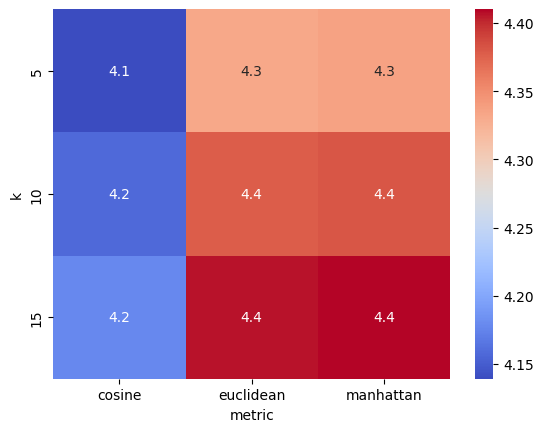

In [18]:
plot_heatmap(tuning_result)

### **Content-Based Collaborative Filtering Algorithm**

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances


class CBCF:
    def __init__(self):
        self.df = None
        self.tfidf_matrix = None
        self.similarity_metric = None
        self.user_ratings = None
        self.recipe_names = None

    def fit(self, dataset, metric):
        # Load the dataset into a pandas DataFrame

        similarity_metric = getattr(skl.metrics.pairwise, metric)

        self.df = dataset
        
        # Vectorize the ingredients column
        tfidf = TfidfVectorizer()
        self.tfidf_matrix = tfidf.fit_transform(self.df['ingredients'].apply(' '.join))
        print(self.tfidf_matrix)
        # Calculate similarity between the TF-IDF feature matrix and itself
        self.similarity_matrix = similarity_metric(self.tfidf_matrix, self.tfidf_matrix)

        self.recipe_names = self.df['recipe_name']
        print(self.similarity_matrix)

    def predict_rating(self, user_id, recipe_id):
        # Find all recipes that the user has rated
        self.user_ratings = self.df[self.df['user_id'] == user_id]
        # print(self.user_ratings)
        # Calculate the similarity between the target recipe and all recipes the user has rated
        recipe_index = self.df[self.df['recipe_id'] == recipe_id].index[0] if len(self.df[self.df['recipe_id'] == recipe_id]) > 0 else -1
        sim_scores = self.similarity_matrix[recipe_index]
        recipe_indices = dict(zip(self.df['recipe_id'], range(len(self.df))))

# Find the indices of the rows corresponding to the rated recipes using the dictionary
        rated_indices = [recipe_indices[x] for x in self.user_ratings['recipe_id']]
        user_sim_scores = sim_scores[rated_indices]

        # Use the similarity scores and the user's ratings to calculate a weighted average
        weights = user_sim_scores
        ratings = self.user_ratings['rating']
        predicted_rating = np.dot(weights, ratings) / weights.sum()

        # Return the weighted average as the predicted rating
        return predicted_rating
  
def train(data_train, metric):
  model = CBCF()
  model.fit(data_train, metric)
  y_true = []
  y_pred = []
  for i, row in data_train.iterrows():
      # print(row['user_id'])
      rating_pred = model.predict_rating(row['user_id'], row['recipe_id'])
      if rating_pred is not None:
          y_true.append(row['rating'])
          y_pred.append(rating_pred)
  y_pred = np.nan_to_num(y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  return rmse

  
def test_CB(data_test):
  model = CBCF()
  model.fit(data_test, "cosine_similarity")
  y_true = []
  y_pred = []
  for i, row in data_test.iterrows():
      # print(row['user_id'])
      rating_pred = model.predict_rating(row['user_id'], row['recipe_id'])
      if rating_pred is not None:
          y_true.append(row['rating'])
          y_pred.append(rating_pred)
  y_pred = np.nan_to_num(y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  return rmse

### **Content-Based Collaborative Filtering Tuning**

In [ ]:
def tune_hyperparameters_CB(data_train,metric_range):
    results = []
    best_rmse = np.inf
    best_metric = None
    for metric in metric_range:
      print(f'Training with metric={metric}...')          
      rmse = train(data_train, metric)
      results.append({'metric': metric, 'rmse': rmse})
      print("rmse: ", rmse)
      if rmse < best_rmse:
        best_rmse = rmse
        best_metric = metric
    print('best_rmse : ', best_rmse, 'best_metric : ', best_metric)
    return results

In [ ]:
metric_range = [ "cosine_similarity", "euclidean_distances", "manhattan_distances"]
tuning_result = tune_hyperparameters_CB(data_train, metric_range)
print(tuning_result)


In [ ]:
df = pd.DataFrame(tuning_result)

df

metric      rmse
0    cosine_similarity  0.564554
1  euclidean_distances  1.240607
2  manhattan_distances  1.240621

### **Hybrid Algorithm**

In [ ]:
class Hybrid:
    def __init__(self):
        self.df = None
        self.tfidf_matrix = None
        self.similarity_metric = None
        self.user_ratings = None
        self.recipe_names = None

        self.k = 5
        self.metric = "cosine_similarity"


    def fit(self, dataset):
        # Load the dataset into a pandas DataFrame

        similarity_metric = similarity_metric = getattr(skl.metrics.pairwise, self.metric)

        self.df = dataset
        
        self.recipe_user_matrix = pd.pivot_table(self.df, values='rating', index=['recipe_id'], columns=['user_id'])
        self.recipe_user_matrix = self.recipe_user_matrix.fillna(0)
        self.model = NearestNeighbors(metric="cosine", algorithm='auto', n_neighbors=self.k)


        # Vectorize the ingredients column
        tfidf = TfidfVectorizer()
        self.tfidf_matrix = tfidf.fit_transform(self.df['ingredients'].apply(' '.join))
        self.tfidf_matrix = self.tfidf_matrix.tocsr()
        # Calculate similarity between the TF-IDF feature matrix and itself
        self.similarity_matrix = similarity_metric(self.tfidf_matrix, self.tfidf_matrix)

        self.recipe_names = self.df['recipe_name']

        self.model.fit(self.recipe_user_matrix.T.values)
        self.similarity, self.indices = self.model.kneighbors(self.recipe_user_matrix.T.values, return_distance=True)

    def predict_content_based(self, user_id, recipe_id):
        # Find all recipes that the user has rated
        self.user_ratings = self.df[self.df['user_id'] == user_id]

        # Calculate the similarity between the target recipe and all recipes the user has rated
        recipe_index = self.df[self.df['recipe_id'] == recipe_id].index[0]
        sim_scores = self.similarity_matrix[recipe_index]
        recipe_indices = dict(zip(self.df['recipe_id'], range(len(self.df))))

        # Find the indices of the rows corresponding to the rated recipes using the dictionary
        rated_indices = [recipe_indices[x] for x in self.user_ratings['recipe_id']]
        user_sim_scores = sim_scores[rated_indices]

        # Use the similarity scores and the user's ratings to calculate a weighted average
        weights = user_sim_scores
        ratings = self.user_ratings['rating']
        predicted_rating = np.dot(weights, ratings) / weights.sum()

        # Return the weighted average as the predicted rating
        return predicted_rating

    def predict_user_based(self, user_id, recipe_id): 
        user_index = self.recipe_user_matrix.columns.get_loc(user_id)
        recipe_index = self.recipe_user_matrix.index.get_loc(recipe_id)
        nn_ratings = []
        nn_similarities = []

        for i in range(len(self.indices[user_index])):
            ind = self.indices[user_index][i]
            if not pd.isna(self.recipe_user_matrix.iloc[recipe_index, ind]):
                nn_ratings.append(self.recipe_user_matrix.iloc[recipe_index, ind])
                nn_similarities.append(self.similarity[user_index, i ])
        if len(nn_ratings) > 0:
          # normalize ratings to range from 0 to 1
          max_rating = 5.0
          min_rating = 0.0
          nn_ratings_norm = [(r - min_rating) / (max_rating - min_rating) for r in nn_ratings]

          # compute weighted sum of normalized ratings
          pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)
        
        # denormalize prediction back to original rating range
          pred = pred_norm * (max_rating - min_rating) + min_rating
        
          return pred
        else:
          return None


    def predict_hybrid(self, user_id, recipe_id, UB_weightage):
        # Predict the rating using user-based algorithm
        user_based_rating = self.predict_user_based(user_id, recipe_id)

        # Predict the rating using content-based algorithm
        content_based_rating = self.predict_content_based(user_id, recipe_id)

        # If both ratings are available, calculate the weighted average
        if user_based_rating is not None and content_based_rating is not None:
          
          hybrid_rating = UB_weightage * user_based_rating + (1-UB_weightage) * content_based_rating
          return hybrid_rating

        # If only one rating is available, return that rating
        elif user_based_rating is not None:
          return user_based_rating

        elif content_based_rating is not None:
          return content_based_rating

        # If neither rating is available, return None
        else:
          return None

def train(data_train, w):
  model = Hybrid()
  model.fit(data_train)
  y_true = []
  y_pred = []
  for i, row in data_train.iterrows():
      # print(row['user_id'])
      rating_pred = model.predict_hybrid(row['user_id'], row['recipe_id'], w)
      if rating_pred is not None:
          y_true.append(row['rating'])
          y_pred.append(rating_pred)
  y_pred = np.nan_to_num(y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  return rmse

def test_hybrid(data_test):
  model = Hybrid()
  model.fit(data_test)
  y_true = []
  y_pred = []
  for i, row in data_test.iterrows():
      # print(row['user_id'])
      rating_pred = model.predict_hybrid(row['user_id'], row['recipe_id'], 0.1)
      if rating_pred is not None:
          y_true.append(row['rating'])
          y_pred.append(rating_pred)
  y_pred = np.nan_to_num(y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  return rmse

### **Hybrid Algorithm Tuning**

In [ ]:
def tune_hyperparameters_Hybrid(data_train,weightage_range):
    results = []
    best_rmse = np.inf
    best_metric = None
    for w in weightage_range:
      print(f'Training with weightage={w}...')          
      rmse = train(data_train, w)
      results.append({'UB_weightage': w, 'rmse': rmse})
      print("rmse: ", rmse)
      if rmse < best_rmse:
        best_rmse = rmse
        best_weightage = w
    print('best_rmse : ', best_rmse, 'best_weightage : ', best_weightage)
    return results

In [ ]:
weightage_range = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
tuning_result = tune_hyperparameters_Hybrid(data_train, weightage_range)
print(tuning_result)

Training with weightage=0.1...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.19087936589421758
  (23738, 1225)	0.

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  0.7179850277846939
Training with weightage=0.2...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.1908793658

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  1.0116421732360736
Training with weightage=0.3...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.1908793658

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  1.365992652690904
Training with weightage=0.4...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.19087936589

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  1.7444341838344506
Training with weightage=0.5...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.1908793658

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  2.134189300470721
Training with weightage=0.6...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.19087936589

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  2.53003477698354
Training with weightage=0.7...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.190879365894

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  2.9295027955674495
Training with weightage=0.8...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.1908793658

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  3.331290431607212
Training with weightage=0.9...
  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.19087936589

<ipython-input-11-7b34691b28c6>:80: RuntimeWarning: invalid value encountered in double_scalars
  pred_norm = sum([r * s for r, s in zip(nn_ratings_norm, nn_similarities)]) / sum(nn_similarities)


rmse:  3.734649100543039
best_rmse :  0.7179850277846939 best_weightage :  0.1
[{'UB_weightage': 0.1, 'rmse': 0.7179850277846939}, {'UB_weightage': 0.2, 'rmse': 1.0116421732360736}, {'UB_weightage': 0.3, 'rmse': 1.365992652690904}, {'UB_weightage': 0.4, 'rmse': 1.7444341838344506}, {'UB_weightage': 0.5, 'rmse': 2.134189300470721}, {'UB_weightage': 0.6, 'rmse': 2.53003477698354}, {'UB_weightage': 0.7, 'rmse': 2.9295027955674495}, {'UB_weightage': 0.8, 'rmse': 3.331290431607212}, {'UB_weightage': 0.9, 'rmse': 3.734649100543039}]


In [ ]:
import matplotlib.pyplot as plt

def plot_tuning_results(tuning_result):
    # Extract the weightage values and RMSE values from the list of dictionaries
    weightage_values = [result['UB_weightage'] for result in tuning_result]
    rmse_values = [result['rmse'] for result in tuning_result]

    # Create a line plot of the RMSE values vs. weightage values
    plt.plot(weightage_values, rmse_values)
    plt.title('Tuning Results')
    plt.xlabel('UB Weightage')
    plt.ylabel('RMSE')
    plt.show()

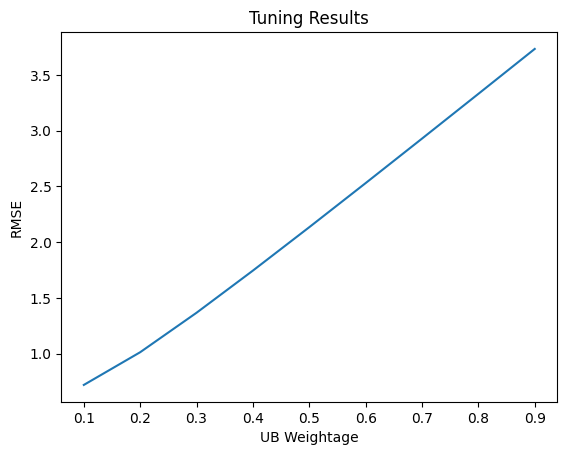

In [ ]:
plot_tuning_results(tuning_result)

## Comparing Algorithm Performance

In [ ]:

def algorithm_comparison(data):
  algorithms = ["User-based", "Content-based", "Hybrid"]
  rmse_UB = test_UB(data) 
  rmse_CB = test_CB(data) 
  rmse_hybrid = test_hybrid(data) 
  
  result = [{'algorithm': algorithms[0], 'rmse': rmse_UB}, {'algorithm': algorithms[1], 'rmse': rmse_CB}, {'algorithm': algorithms[2], 'rmse': rmse_hybrid}]

  result_df = pd.DataFrame(result)

  return result_df

In [ ]:
test_comp = algorithm_comparison(data_test)

  (0, 597)	0.1886864380618109
  (0, 545)	0.25094087657120756
  (0, 1656)	0.24807729050541472
  (0, 526)	0.19009897747984833
  (0, 980)	0.2311024659260972
  (0, 1526)	0.16831659417469153
  (0, 292)	0.1975792525884395
  (0, 408)	0.4471625147895164
  (0, 215)	0.1740460247489018
  (0, 402)	0.47178839797716576
  (0, 670)	0.4797281821397314
  (1, 136)	0.5465173306087248
  (1, 1072)	0.20721567452699016
  (1, 996)	0.33107216412263757
  (1, 228)	0.4628093140624784
  (1, 545)	0.27529120103874577
  (1, 1656)	0.2721497437436995
  (1, 526)	0.20854544122792573
  (1, 1526)	0.18464938035694461
  (1, 292)	0.21675157307412563
  (1, 408)	0.24527671106819612
  (2, 445)	0.5256819649706063
  (2, 319)	0.2726380038298066
  (2, 986)	0.41687113557021904
  (2, 1682)	0.19256463051928704
  :	:
  (23738, 208)	0.28510486168283705
  (23738, 719)	0.2910084895893812
  (23738, 1710)	0.1966773406036366
  (23738, 1350)	0.25624900266323963
  (23738, 310)	0.19087936589421758
  (23738, 1225)	0.11392302966794522
  (23738, 304

In [ ]:
test_comp


algorithm      rmse
0     User-based  4.055071
1  Content-based  0.406785
2         Hybrid  0.617491

## Health Weightage

### **FSA Score Calculation**

In [22]:
unique_recipes = data_full.drop_duplicates(subset='recipe_id')

In [23]:
unique_recipes

user_id  recipe_id  rating  calories   fat  saturatedFat sodium  \
0      5215572      17991       5     463.0  24.3          12.5    971   
1      5215572     170724       4     210.0   6.0           0.9    121   
2      5215572      18045       5     196.0  14.8           7.7    463   
3      3622615      60598       4     462.0  31.1          15.3   1434   
4      1313770      47519       5     468.0  18.7           7.7    678   
...        ...        ...     ...       ...   ...           ...    ...   
29662  2940585      85837       5     763.0  21.7           7.9   1623   
29667  2498083     112239       5     486.0  35.0          20.9    363   
29671  2498083      11109       5     266.0   8.3           5.0    104   
29674  2498083     143090       5     588.0  28.0           7.4    402   
29675  2498083      33352       4     487.0  37.6          23.0    594   

       sugars                                        ingredients  \
0        12.2  [bell peppers, salt, ground beef, onion, salt ...   
1        11.2  [butternut squash, carrot, potato, rutabaga pi...   
2         1.7  [squash, onion, buttery round crackers, chedda...   
3         9.3  [oil, onion, ginger root, garlic, potato, carr...   
4        36.5  [butter, mushroom, cream cheese, skinless bone...   
...       ...                                                ...   
29662    21.4  [rice chicken sauce mix broccoli, oil, ground ...   
29667    23.8  [graham cracker crumbs, butter, sugar, cream c...   
29671    28.5  [butter, sugar, egg, vanilla extract, flour, p...   
29674    25.6  [soy sauce, sugar, potato starch, sesame oil, ...   
29675     0.5  [butter, mushroom, lobster meat, flour, chicke...   

                                  recipe_name  
0                     Stuffed Green Peppers I  
1      Sean's Mommy's Roasted Root Vegetables  
2                     Yellow Squash Casserole  
3                            Vegetarian Korma  
4                        Cream Cheese Chicken  
...                                       ...  
29662                Spicy Chicken Enchiladas  
29667            Caramel Macchiato Cheesecake  
29671                          Empire Cookies  
29674           Hong Kong Sweet and Sour Pork  
29675                    Lobster Mornay Sauce  

[10728 rows x 10 columns]

In [24]:
fat_high = 17.5
fat_low = 3.0
sat_fat_high = 5.0
sat_fat_low = 1.5
sugars_high = 22.5
sugars_low = 5.0
sodium_high = 900
sodium_low = 300

def calculate_FSA_score(row):
    fat = int(row['fat'])
    satFat = int(row['saturatedFat'])
    sugars = int(row['sugars'])
    sodium = int(row['sodium'])
    
    score = 0
    if fat > fat_high:
        score += 3
    elif fat_low < fat <= fat_high:
        score += 2
    elif fat <= fat_low:
        score += 1
    if satFat > sat_fat_high:
        score += 3
    elif sat_fat_low < satFat <= sat_fat_high:
        score += 2
    elif satFat <= sat_fat_low:
        score += 1
    if sugars > sugars_high:
        score += 3
    elif sugars_low < sugars <= sugars_high:
        score += 2
    elif sugars <= sugars_low:
        score += 1
    if sodium > sodium_high:
        score += 3
    elif sodium_low < sodium <= sodium_high:
        score += 2
    elif sodium <= sodium_low:
        score += 1

    return score

unique_recipes['FSA_score'] = unique_recipes.apply(calculate_FSA_score, axis=1)


<ipython-input-24-e1caf0f93c80>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_recipes['FSA_score'] = unique_recipes.apply(calculate_FSA_score, axis=1)


In [ ]:
unique_recipes

user_id  recipe_id  rating  calories   fat  saturatedFat sodium  \
0      5215572      17991       5     463.0  24.3          12.5    971   
1      5215572     170724       4     210.0   6.0           0.9    121   
2      5215572      18045       5     196.0  14.8           7.7    463   
3      3622615      60598       4     462.0  31.1          15.3   1434   
4      1313770      47519       5     468.0  18.7           7.7    678   
...        ...        ...     ...       ...   ...           ...    ...   
29662  2940585      85837       5     763.0  21.7           7.9   1623   
29667  2498083     112239       5     486.0  35.0          20.9    363   
29671  2498083      11109       5     266.0   8.3           5.0    104   
29674  2498083     143090       5     588.0  28.0           7.4    402   
29675  2498083      33352       4     487.0  37.6          23.0    594   

       sugars                                        ingredients  \
0        12.2  [green bell peppers, salt to taste, ground bee...   
1        11.2  [butternut squash, carrots, large sweet potato...   
2         1.7  [sliced yellow squash, chopped onion, buttery ...   
3         9.3  [vegetable oil, small onion, minced fresh ging...   
4        36.5  [butter, fresh mushrooms sliced, cream cheese,...   
...       ...                                                ...   
29662    21.4  [dry rice and chicken sauce mix with broccoli,...   
29667    23.8  [graham cracker crumbs, butter, white sugar, c...   
29671    28.5  [butter, white sugar, egg, vanilla extract, al...   
29674    25.6  [light soy sauce, white sugar, potato starch, ...   
29675     0.5  [butter, sliced fresh mushrooms, lobster meat ...   

                                  recipe_name  FSA_score  
0                     Stuffed Green Peppers I         11  
1      Sean's Mommy's Roasted Root Vegetables          6  
2                     Yellow Squash Casserole          8  
3                            Vegetarian Korma         11  
4                        Cream Cheese Chicken         11  
...                                       ...        ...  
29662                Spicy Chicken Enchiladas         11  
29667            Caramel Macchiato Cheesecake         11  
29671                          Empire Cookies          8  
29674           Hong Kong Sweet and Sour Pork         11  
29675                    Lobster Mornay Sauce          9  

[10728 rows x 11 columns]

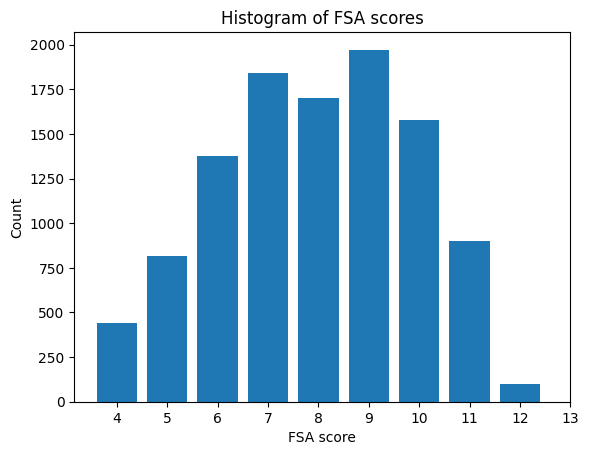

In [ ]:
import matplotlib.pyplot as plt

# Filter FSA scores between 4 and 12
fsa_scores = unique_recipes['FSA_score']

# Plot histogram of FSA scores
plt.hist(fsa_scores, bins=range(4, 14), align='left', rwidth=0.8)
plt.xticks(range(4, 14))
plt.xlabel('FSA score')
plt.ylabel('Count')
plt.title('Histogram of FSA scores')
plt.show()

### **Adding Health Weightage** 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
class CBCF_health:
    def __init__(self):
        self.df = None
        self.tfidf_matrix = None
        self.cosine_sim = None
        self.user_ratings = None
        self.recipe_names = None
        self.health_weightage = None

        self.fat_high = 17.5
        self.fat_low = 3.0
        self.sat_fat_high = 5.0
        self.sat_fat_low = 1.5
        self.sugars_high = 22.5
        self.sugars_low = 5.0
        self.sodium_high = 900
        self.sodium_low = 300

    def fit(self, dataset, health_weightage):
        # Load the dataset into a pandas DataFrame
        self.df = dataset
        
        # Vectorize the ingredients column
        tfidf = TfidfVectorizer()
        self.tfidf_matrix = tfidf.fit_transform(self.df['ingredients'].apply(' '.join))

        # Calculate cosine similarity between the TF-IDF feature matrix and itself
        self.cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)

        self.recipe_names = self.df['recipe_name']

        self.health_weightage = health_weightage

    def FSA_score(self, recipe_id):
        target_recipe = self.df[self.df['recipe_id'] == recipe_id]
        calories = int(target_recipe['calories'].values[0])
        fat = int(target_recipe['fat'].values[0])
        satFat = int(target_recipe['saturatedFat'].values[0])
        sugars = int(target_recipe['sugars'].values[0])
        sodium = int(target_recipe['sodium'].values[0])

        score = 0
        if fat > self.fat_high:
            score += 3
        elif self.fat_low < fat <= self.fat_high:
            score += 2
        elif fat <= self.fat_low:
            score += 1
        if satFat > self.sat_fat_high:
            score += 3
        elif self.sat_fat_low < satFat <= self.sat_fat_high:
            score += 2
        elif satFat <= self.sat_fat_low:
            score += 1
        if sugars > self.sugars_high:
            score += 3
        elif self.sugars_low < sugars <= self.sugars_high:
            score += 2
        elif sugars <= self.sugars_low:
            score += 1
        if sodium > self.sodium_high:
            score += 3
        elif self.sodium_low < sodium <= self.sodium_high:
            score += 2
        elif sodium <= self.sodium_low:
            score += 1

        return score
    
    def predict_rating(self, user_id, recipe_id, healthy):
        # Find all recipes that the user has rated
        self.user_ratings = self.df[self.df['user_id'] == user_id]

        # Calculate the cosine similarity between the target recipe and all recipes the user has rated
        recipe_index = self.df[self.df['recipe_id'] == recipe_id].index[0]
        sim_scores = self.cosine_sim[recipe_index]
        rated_indices = [self.df[self.df['recipe_id'] == x].index[0] for x in self.user_ratings['recipe_id']]
        user_sim_scores = sim_scores[rated_indices]    

        # Use the similarity scores and the user's ratings to calculate a weighted average
        weights = user_sim_scores 
        ratings = self.user_ratings['rating']
        predicted_rating = np.dot(weights, ratings) / weights.sum()

        if(healthy == True):
          fsa_score = self.FSA_score(recipe_id)

          # Normalize the FSA score to a range of 0 to 1
          normalized_fsa_score = (fsa_score - 4) / 8  # Adjust the range to 0-1

          if fsa_score <= 9:
            health_weightage = (1-normalized_fsa_score) * self.health_weightage   # Increase the weightage for healthy recipes
            predicted_rating = predicted_rating * (1 - health_weightage) + health_weightage * 5

        print("post PR",predicted_rating)
        # Return the weighted average as the predicted rating
        return predicted_rating

    def top_recipe_names(self, user_id, healthy):
      # Predict the rating for each recipe and store in a DataFrame
      recipe_ids = self.df['recipe_id'].unique()
      predicted_ratings = []
      fsa_scores = []
      for recipe_id in recipe_ids:
        predicted_rating = self.predict_rating(user_id, recipe_id, healthy)
        predicted_ratings.append(predicted_rating)
        fsa_score = self.FSA_score(recipe_id)
        fsa_scores.append(fsa_score)
        
      df_predicted = pd.DataFrame({'recipe_id': recipe_ids, 'predicted_rating': predicted_ratings, 'fsa_score': fsa_scores})
      # Sort the DataFrame by predicted rating in descending order and select the top 20
      df_predicted_sorted = df_predicted.sort_values(by='predicted_rating', ascending=False)
      top_recipe_ids = df_predicted_sorted.head(20)['recipe_id'].values
      top_recipe_fsa_scores = df_predicted_sorted[df_predicted_sorted['recipe_id'].isin(top_recipe_ids)]['fsa_score'].values

      average_fsa_score = np.mean(top_recipe_fsa_scores)

      return average_fsa_score

    def test(self, data):
        self.df = data
        predicted_ratings = []
        for i, row in self.data.iterrows():
            user_id = row['user_id']
            recipe_id = row['recipe_id']
            predicted_rating = self.predict_rating(user_id, recipe_id)
            predicted_ratings.append(predicted_rating)
        actual_ratings = self.data['rating'].tolist()
        rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
        return rmse
  
def train(data_test, weightage, healthy):
  model = CBCF_health()
  model.fit(data_test,weightage)
  y_true = []
  y_pred = []
  for i, row in data_test.iterrows():
      # print(row['user_id'])
      rating_pred = model.predict_rating(row['user_id'], row['recipe_id'], healthy)
      if rating_pred is not None:
          y_true.append(row['rating'])
          y_pred.append(rating_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  return rmse

def train_average(data_test, weightage):
  model = CBCF_health()
  model.fit(data_test,weightage)
  FSA_avg = []
  user_ids = data_test['user_id'].unique()[10:15]
  print(len(user_ids))
  # FSA_mean = model.top_recipe_names(user_ids[0], healthy)

  for user_id in user_ids:
      # print(row['user_id'])
      FSA_before = model.top_recipe_names(user_id, False)
      FSA_after = model.top_recipe_names(user_id, True)
      if FSA_before is not None and FSA_after is not None:
        FSA_avg.append({'User_id': user_id, 'FSA_Before': FSA_before,'FSA_after' : FSA_after })
        print(FSA_avg)
        # FSA_avg.append(FSA_pred)
  # FSA_mean = np.mean(FSA_avg)
  return FSA_avg


### **Health Weightage Tuning**

In [28]:
def tune_hyperparameters_Healthy(data_train,weightage_range):
    results = []
    best_rmse = np.inf
    best_metric = None
    base_result = train(data_test, 0, False)
    results.append({'Health_weightage': 0, 'rmse': base_result})
    for w in weightage_range:
      print(f'Training with weightage={w}...')          
      rmse = train(data_test, w, True)
      results.append({'Health_weightage': w, 'rmse': rmse})
      print("rmse: ", rmse)
      if rmse < best_rmse:
        best_rmse = rmse
        best_weightage = w
    print('best_rmse : ', best_rmse, 'best_weightage : ', best_weightage)
    return results

weightage_range = [0.3,0.6,0.9]
tuning_result = tune_hyperparameters_Healthy(data_train, weightage_range)
print(tuning_result)

Streaming output truncated to the last 5000 lines.
post PR 4.4588464075940255
Best Steak Marinade in Existence
pre PR 5.0
6
post PR 5.0
Microwave Bread and Butter Pickles
pre PR 4.597598813781131
5
post PR 4.91448974792849
Mrs. Sigg's Snickerdoodles
pre PR 4.848373659429826
6
post PR 4.950721439314693
Divinity
pre PR 3.998882966082013
6
post PR 4.6746369639766545
Spicy Chicken-n-Cheese Balls
pre PR 4.149005566986673
11
post PR 4.149005566986673
Mom's Best Pork Chops
pre PR 3.9266489099173674
8
post PR 4.409656900454552
Johnny Marzetti Casserole
pre PR 4.084191172529049
11
post PR 4.084191172529049
Pretzel Turtles®
pre PR 4.0904271680028765
4
post PR 4.909042716800288
Grandma's Chicken Noodle Soup
pre PR 5.0
6
post PR 5.0
Herb Rubbed Sirloin Tip Roast
pre PR 4.1060566076543275
10
post PR 4.1060566076543275
Best Tuna Casserole
pre PR 3.037075154666484
10
post PR 3.037075154666484
Awesome Bow Tie Pasta
pre PR 4.899395514982743
7
post PR 4.95598553780495
Potato Chips
pre PR 2.7840772675003

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tuning_results_health(tuning_result):
    # Extract the RMSE values for each weightage value
    weightage_values = [0, 0.3, 0.6, 0.9]
    rmse_values = [result['rmse'] for result in tuning_result]

    # Define the colors for each weightage value
    colors = ['blue', 'green', 'orange', 'red']

    # Calculate the width of each bar to make them equal
    bar_width = 0.2

    # Create a bar graph with equal-width bars for each weightage value
    plt.bar(weightage_values, rmse_values, width=bar_width, color=colors)

    # Set the x-axis limits to center the bars
    plt.xlim(-bar_width, max(weightage_values) + bar_width)

    # Set the x-axis labels, title, and axis labels
    plt.xticks(weightage_values)
    plt.title('Effect of Health Weightage')
    plt.xlabel('Health Weightage')
    plt.ylabel('RMSE')

    # Show the plot
    plt.show()

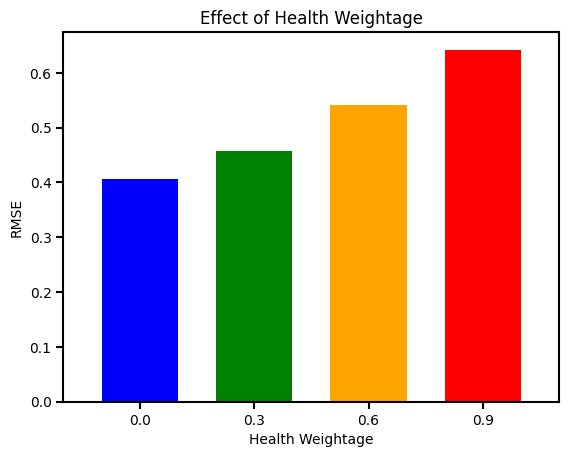

In [40]:
plot_tuning_results_health(tuning_result)

### **Change in Recommended Recipes' Mean FSA Score**

In [15]:

FSA_before_03 = train_average(data_test,0.3)
FSA_before_03


5
World's Best Lasagna
pre PR 3.543891950466551
post PR 3.543891950466551
Roasted Garlic Lemon Broccoli
pre PR 3.4621817750012904
post PR 3.4621817750012904
Mrs. Sigg's Snickerdoodles
pre PR 3.440064302356578
post PR 3.440064302356578
Garlic Creamed Chicken
pre PR 3.078922549978569
post PR 3.078922549978569
Traci's Chicken Noodle Casserole
pre PR 3.117320624598932
post PR 3.117320624598932
Irish Potato Candy
pre PR 3.3933747050518477
post PR 3.3933747050518477
Mama's Dormant Chicken
pre PR 3.2036761941118943
post PR 3.2036761941118943
Homemade Focaccia Bread
pre PR 3.6136792451841493
post PR 3.6136792451841493
Best Ever Spinach Artichoke Dip
pre PR 3.5633627234770517
post PR 3.5633627234770517
Easy Meatloaf
pre PR 3.37090907724579
post PR 3.37090907724579
Apple Filled Chicken in Pecan Creme Sauce
pre PR 3.042078984242158
post PR 3.042078984242158
Quick and Easy Pizza Crust
pre PR 3.761314122910128
post PR 3.761314122910128
Quick and Easy Alfredo Sauce
pre PR 3.4780964700440706
post PR 

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 3.616290143880794
post PR 3.616290143880794
Fig and Olive Tapenade
pre PR 3.378051693032684
post PR 3.378051693032684
Bacon-Roasted Chicken with Potatoes
pre PR 3.7402183442379275
post PR 3.7402183442379275
Bacon Mushroom Chicken
pre PR 3.3509192264394962
post PR 3.3509192264394962
Gourmet Chicken Pizza
pre PR 3.3371170543778645
post PR 3.3371170543778645
Addictive Pumpkin Muffins
pre PR 3.744423382420497
post PR 3.744423382420497
Tortilla Rollups II
pre PR 3.568652794592229
post PR 3.568652794592229
Fudge Brownies I
pre PR 3.3260205940202825
post PR 3.3260205940202825
Praline Sweet Potatoes
pre PR 3.3862692497357014
post PR 3.3862692497357014
Thai Pineapple Chicken Curry
pre PR 3.215784108270617
post PR 3.215784108270617
Dill Wrapped Cream Cheese
pre PR 3.347121581913981
post PR 3.347121581913981
Hearty Lentil Soup II
pre PR 3.0
post PR 3.0
Oranged Cranberry Sauce
pre PR 3.851444607216664
post PR 3.851444607216664
PHILADELPHIA 

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.35039060192131
post PR 4.35039060192131
Ellen's Buffalo Meatloaf
pre PR 4.230902604809377
post PR 4.230902604809377
Peanut Butter Popcorn
pre PR 4.304704249977269
post PR 4.304704249977269
Beef Stew VI
pre PR 4.159157411176635
post PR 4.159157411176635
Mom's 'Sweet 'n' Sours' Pork Ribs
pre PR 4.117363144521505
post PR 4.117363144521505
Grandma Ople's Apple Pie
pre PR 4.155459010529099
post PR 4.155459010529099
Lime Chicken Soft Tacos
pre PR 4.0652281807230315
post PR 4.0652281807230315
Real Chiles Rellenos
pre PR 4.141355797358589
post PR 4.141355797358589
Salisbury Steak
pre PR 4.228863144233563
post PR 4.228863144233563
Tunnel of Fudge Cake II
pre PR 4.140892829826872
post PR 4.140892829826872
Deep Dish Brownies
pre PR 4.126000280467572
post PR 4.126000280467572
Chicken Katsu
pre PR 4.037633687368791
post PR 4.037633687368791
Cold Crawfish Dip
pre PR 4.160279248672317
post PR 4.160279248672317
Plum Clafouti
pre PR 4.28926207

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.230902604809377
post PR 4.375108366407619
Peanut Butter Popcorn
pre PR 4.304704249977269
post PR 4.304704249977269
Beef Stew VI
pre PR 4.159157411176635
post PR 4.253752202419264
Mom's 'Sweet 'n' Sours' Pork Ribs
pre PR 4.117363144521505
post PR 4.117363144521505
Grandma Ople's Apple Pie
pre PR 4.155459010529099
post PR 4.155459010529099
Lime Chicken Soft Tacos
pre PR 4.0652281807230315
post PR 4.2404978968374625
Real Chiles Rellenos
pre PR 4.141355797358589
post PR 4.141355797358589
Salisbury Steak
pre PR 4.228863144233563
post PR 4.315616040507287
Tunnel of Fudge Cake II
pre PR 4.140892829826872
post PR 4.140892829826872
Deep Dish Brownies
pre PR 4.126000280467572
post PR 4.224325248914971
Chicken Katsu
pre PR 4.037633687368791
post PR 4.254166107710812
Cold Crawfish Dip
pre PR 4.160279248672317
post PR 4.2862373613714695
Plum Clafouti
pre PR 4.289262078477652
post PR 4.44917811082018
Grilled Lemon Herb Pork Chops
pre PR 4.2

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Peanut Butter Chip Chocolate Cookies
pre PR 4.117133146179976
post PR 4.117133146179976
Indonesian Spiced Rice
pre PR 4.2382777402329905
post PR 4.438229833421831
Smoked Salmon Vodka Cream Sauce
pre PR 4.272735511216367
post PR 4.354552766204526
Blackened Tuna Steaks with Mango Salsa
pre PR 4.158949426664897
post PR 4.158949426664897
Bean Soup With Kale
pre PR 4.167494671100302
post PR 4.417246269770211
Avocado Soup with Chicken and Lime
pre PR 4.091417589425565
post PR 4.227704951011731
Carrot Cake XI
pre PR 4.155896116815316
post PR 4.314165594912444
New Orleans Barbeque Shrimp
pre PR 4.175053489868081
post PR 4.267859972257922
Classic Caramel Corn
pre PR 4.318894673709263
post PR 4.318894673709263
Fancy Pimento Cheese
pre PR 4.144542461873325
post PR 4.240781434912575
Pesto Chicken
pre PR 4.094557321559048
post PR 4.23037372332519
Corn Pudding V
pre PR 4.365358476448488
post PR 4.484353762114397
Ginger Dipping Sauce
pre PR 4.07768012375819
post PR 4.319789091271666
Lentil Loaf
pre P

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 3.8913750980363697
post PR 3.8913750980363697
Jalapeno Chicken II
pre PR 4.0
post PR 4.0
Spinach Quiche with Kid Appeal
pre PR 3.9717909397080615
post PR 3.9717909397080615
Apple Butter Pumpkin Pie
pre PR 4.110622316059301
post PR 4.110622316059301
Chicken Fried Steak I
pre PR 4.275427638432767
post PR 4.275427638432767
Foolproof Chocolate Fudge
pre PR 4.169802582788937
post PR 4.169802582788937
Crab Stuffed Haddock
pre PR 3.9578244030502607
post PR 3.9578244030502607
Guyanese Lime Cookies
pre PR 3.84067663526316
post PR 3.84067663526316
Bread Pudding
pre PR 3.9311317483885433
post PR 3.9311317483885433
Jim's Macaroni Salad
pre PR 4.003558713361013
post PR 4.003558713361013
Award Winning Chili
pre PR 3.902997906535008
post PR 3.902997906535008
Cucumber and Blue Cheese Salad
pre PR 3.7590980419444855
post PR 3.7590980419444855
Linguine with Seafood and Sundried Tomatoes
pre PR 3.813226851332835
post PR 3.813226851332835
Hawaiian 

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.39351392135343
post PR 4.39351392135343
Rice with Black Beans
pre PR 4.515945268055093
post PR 4.515945268055093
Rosenmunnar
pre PR 4.471782134987724
post PR 4.471782134987724
Cube Steak Parmesan
pre PR 4.443672756923733
post PR 4.443672756923733
Big Ed's Cajun Shrimp Soup
pre PR 4.316689510749549
post PR 4.316689510749549
The Best Meatballs You'll Ever Have
pre PR 4.367390061449206
post PR 4.367390061449206
Mongolian Beef I
pre PR 4.412349337466604
post PR 4.412349337466604
Boilermaker Tailgate Chili
pre PR 4.539282679164167
post PR 4.539282679164167
Gel's Green Beans and Beef
pre PR 4.483483079205699
post PR 4.483483079205699
Peanut Butter Cup Cookies
pre PR 4.547227638320097
post PR 4.547227638320097
Raspberry Almond Coffeecake
pre PR 4.649678230331147
post PR 4.649678230331147
Clark Gable Pancakes
pre PR 4.560779476310749
post PR 4.560779476310749
Cake Batter Ice Cream
pre PR 4.7416675893991025
post PR 4.7416675893991025
F

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.5116699165819805
post PR 4.566607050966508
Cheese Dipping Sauce
pre PR 4.390155824633285
post PR 4.481632450938292
Mexican Lasagna II
pre PR 4.697302413332286
post PR 4.697302413332286
Arancini III
pre PR 4.439315805588375
post PR 4.439315805588375
Garlic Chicken
pre PR 4.401551860902131
post PR 4.5362026921991525
Blueberry Crisp I
pre PR 4.6648849698669155
post PR 4.702585410756887
Mom's Buttermilk Pancakes
pre PR 4.39351392135343
post PR 4.484486833150416
Rice with Black Beans
pre PR 4.515945268055093
post PR 4.661161687638565
Rosenmunnar
pre PR 4.471782134987724
post PR 4.630247494491407
Cube Steak Parmesan
pre PR 4.443672756923733
post PR 4.443672756923733
Big Ed's Cajun Shrimp Soup
pre PR 4.316689510749549
post PR 4.4960585141777925
The Best Meatballs You'll Ever Have
pre PR 4.367390061449206
post PR 4.43855867953617
Mongolian Beef I
pre PR 4.412349337466604
post PR 4.522533836691616
Boilermaker Tailgate Chili
pre PR 4.53

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Zucchini Yogurt Multigrain Muffins
pre PR 4.586542526171886
post PR 4.679570457783212
Slow Cooker Honey Garlic Chicken
pre PR 4.134214928628308
post PR 4.264082689334062
Quesadilla Jalapeno Spread
pre PR 4.521017204055542
post PR 4.646750187990962
Texas-Style Baked Beans
pre PR 4.5902585327500285
post PR 4.63635444781565
Garlic Bread Mama Rita's Way!
pre PR 4.55336131709144
post PR 4.637106070136795
Banana Chocolate Chip Cake
pre PR 4.572271484936365
post PR 4.652470581510796
Grandma's Egg Custard Pie
pre PR 4.698606915469327
post PR 4.755118118818828
Broccoli Cheese Soup IV
pre PR 4.588911221086396
post PR 4.588911221086396
Jalapeno-Lime Chicken
pre PR 4.349563669464823
post PR 4.544694568625376
Gravy Baked Pork Chops
pre PR 4.501645918475392
post PR 4.595087308761256
Stuffed French Toast I
pre PR 4.664684771918386
post PR 4.664684771918386
Brunch on the Bayou
pre PR 4.400507578737052
post PR 4.4679504761291335
Chicken Cordon Bleu Casserole
pre PR 4.477794218534723
post PR 4.477794218

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.547421967776853
post PR 4.547421967776853
Pumpkin Cookies VI
pre PR 4.835498385969479
post PR 4.835498385969479
Mexican Chicken Corn Chowder
pre PR 4.707650007180427
post PR 4.707650007180427
No Bake Chocolate Oat Bars
pre PR 4.450576472115535
post PR 4.450576472115535
Mom's Best Waffles
pre PR 4.496927062876195
post PR 4.496927062876195
High Protein Peanut Butter Balls
pre PR 4.617880782459513
post PR 4.617880782459513
Green Beans with Herb Dressing
pre PR 4.737087908570738
post PR 4.737087908570738
Penne Pasta with Veggies
pre PR 4.513009836299434
post PR 4.513009836299434
Frosted Grapes
pre PR 4.307817621907387
post PR 4.307817621907387
Salmon with Fruit Salsa
pre PR 4.4051783272725755
post PR 4.4051783272725755
Carrot Pineapple Cake I
pre PR 4.604620975675849
post PR 4.604620975675849
Banana Bread
pre PR 4.8719320317630785
post PR 4.8719320317630785
Chicken Fiesta Salad
pre PR 4.390220713544027
post PR 4.390220713544027
Ja

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
post PR 4.809120492961985
Barbarella's German Pancakes
pre PR 4.438696046721543
post PR 4.586038334457138
Tuna and Chickpea Salad
pre PR 4.540608900397888
post PR 4.643971897808363
Corn Dog Casserole
pre PR 4.5537077422552485
post PR 4.5537077422552485
Sensational Steak Sandwich
pre PR 4.774304263950145
post PR 4.774304263950145
Slow Cooker Sweet Potato Casserole
pre PR 4.66504899341702
post PR 4.702730981657606
Mexican Cream Cheese Rollups
pre PR 4.66615633277829
post PR 4.66615633277829
Carrot Cake II
pre PR 4.602505909769264
post PR 4.706848108454833
Low Carb Cauliflower Leek Soup
pre PR 4.685870879071548
post PR 4.732990247210816
Chicken Stock Gumbo
pre PR 4.51439590410884
post PR 4.51439590410884
Breaded Turkey Breasts
pre PR 4.773773077185289
post PR 4.807707115607495
Red, Juicy, Herb-Fried Tomatoes
pre PR 4.736262820180878
post PR 4.775823397153746
Best Butternut Squash Soup Ever
pre PR 4.879203497056641
post PR 4.90185284135852

[{'User_id': 1665536, 'FSA_Before': 7.1, 'FSA_after': 7.1},
 {'User_id': 2020451, 'FSA_Before': 6.35, 'FSA_after': 5.95},
 {'User_id': 3254749, 'FSA_Before': 7.6, 'FSA_after': 7.1},
 {'User_id': 1111625, 'FSA_Before': 5.75, 'FSA_after': 5.75},
 {'User_id': 3115014, 'FSA_Before': 6.35, 'FSA_after': 6.85}]

In [16]:
FSA_before_06 = train_average(data_test,0.6)
FSA_before_06

5
World's Best Lasagna
pre PR 3.543891950466551
post PR 3.543891950466551
Roasted Garlic Lemon Broccoli
pre PR 3.4621817750012904
post PR 3.4621817750012904
Mrs. Sigg's Snickerdoodles
pre PR 3.440064302356578
post PR 3.440064302356578
Garlic Creamed Chicken
pre PR 3.078922549978569
post PR 3.078922549978569
Traci's Chicken Noodle Casserole
pre PR 3.117320624598932
post PR 3.117320624598932
Irish Potato Candy
pre PR 3.3933747050518477
post PR 3.3933747050518477
Mama's Dormant Chicken
pre PR 3.2036761941118943
post PR 3.2036761941118943
Homemade Focaccia Bread
pre PR 3.6136792451841493
post PR 3.6136792451841493
Best Ever Spinach Artichoke Dip
pre PR 3.5633627234770517
post PR 3.5633627234770517
Easy Meatloaf
pre PR 3.37090907724579
post PR 3.37090907724579
Apple Filled Chicken in Pecan Creme Sauce
pre PR 3.042078984242158
post PR 3.042078984242158
Quick and Easy Pizza Crust
pre PR 3.761314122910128
post PR 3.761314122910128
Quick and Easy Alfredo Sauce
pre PR 3.4780964700440706
post PR 

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 3.279316442324411
post PR 3.279316442324411
Indiana-Style Fried Cabbage
pre PR 3.6360051933742032
post PR 3.6360051933742032
Scrumptious Salisbury Steak in Mushroom Gravy
pre PR 3.3767849930166984
post PR 3.3767849930166984
Fried Cabbage II
pre PR 3.7608707091118796
post PR 3.7608707091118796
Robey's Blue Crab Deviled Eggs
pre PR 3.616290143880794
post PR 3.616290143880794
Fig and Olive Tapenade
pre PR 3.378051693032684
post PR 3.378051693032684
Bacon-Roasted Chicken with Potatoes
pre PR 3.7402183442379275
post PR 3.7402183442379275
Bacon Mushroom Chicken
pre PR 3.3509192264394962
post PR 3.3509192264394962
Gourmet Chicken Pizza
pre PR 3.3371170543778645
post PR 3.3371170543778645
Addictive Pumpkin Muffins
pre PR 3.744423382420497
post PR 3.744423382420497
Tortilla Rollups II
pre PR 3.568652794592229
post PR 3.568652794592229
Fudge Brownies I
pre PR 3.3260205940202825
post PR 3.3260205940202825
Praline Sweet Potatoes
pre PR 3.38

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.35039060192131
post PR 4.35039060192131
Ellen's Buffalo Meatloaf
pre PR 4.230902604809377
post PR 4.230902604809377
Peanut Butter Popcorn
pre PR 4.304704249977269
post PR 4.304704249977269
Beef Stew VI
pre PR 4.159157411176635
post PR 4.159157411176635
Mom's 'Sweet 'n' Sours' Pork Ribs
pre PR 4.117363144521505
post PR 4.117363144521505
Grandma Ople's Apple Pie
pre PR 4.155459010529099
post PR 4.155459010529099
Lime Chicken Soft Tacos
pre PR 4.0652281807230315
post PR 4.0652281807230315
Real Chiles Rellenos
pre PR 4.141355797358589
post PR 4.141355797358589
Salisbury Steak
pre PR 4.228863144233563
post PR 4.228863144233563
Tunnel of Fudge Cake II
pre PR 4.140892829826872
post PR 4.140892829826872
Deep Dish Brownies
pre PR 4.126000280467572
post PR 4.126000280467572
Chicken Katsu
pre PR 4.037633687368791
post PR 4.037633687368791
Cold Crawfish Dip
pre PR 4.160279248672317
post PR 4.160279248672317
Plum Clafouti
pre PR 4.28926207

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.274770745620568
post PR 4.437947327855941
Alyson's Broccoli Salad
pre PR 4.226857506329967
post PR 4.226857506329967
Extreme Chocolate Cake
pre PR 4.157369369155079
post PR 4.157369369155079
Cornbread and Sausage Stuffing
pre PR 4.296574563361696
post PR 4.56035910210106
Chocolate Sour Cream Fudge
pre PR 4.329861242111295
post PR 4.6816840900028645
Chantal's New York Cheesecake
pre PR 4.210714638151568
post PR 4.210714638151568
Strawnana Smoothie Bread
pre PR 4.35039060192131
post PR 4.691435535912622
Ellen's Buffalo Meatloaf
pre PR 4.230902604809377
post PR 4.519314128005861
Peanut Butter Popcorn
pre PR 4.304704249977269
post PR 4.304704249977269
Beef Stew VI
pre PR 4.159157411176635
post PR 4.348346993661893
Mom's 'Sweet 'n' Sours' Pork Ribs
pre PR 4.117363144521505
post PR 4.117363144521505
Grandma Ople's Apple Pie
pre PR 4.155459010529099
post PR 4.155459010529099
Lime Chicken Soft Tacos
pre PR 4.0652281807230315
post PR 4

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Six Threes Ice Cream
pre PR 4.34760330105439
post PR 4.494392558317152
Diane's Colcannon
pre PR 4.256509426703679
post PR 4.535318391689799
Caramel Brownies II
pre PR 4.260081728984388
post PR 4.260081728984388
Toasted Pumpkin Seeds
pre PR 4.329708608233246
post PR 4.631339734528286
Brenda's Apple and Pomegranate Crisp
pre PR 4.30031919505679
post PR 4.457747376169013
Donut Muffins
pre PR 4.319083055559945
post PR 4.676564451390973
Cheese and Broccoli Chicken Soup
pre PR 4.058215871196517
post PR 4.058215871196517
Peanut Butter Chip Chocolate Cookies
pre PR 4.117133146179976
post PR 4.117133146179976
Indonesian Spiced Rice
pre PR 4.2382777402329905
post PR 4.63818192661067
Smoked Salmon Vodka Cream Sauce
pre PR 4.272735511216367
post PR 4.436370021192685
Blackened Tuna Steaks with Mango Salsa
pre PR 4.158949426664897
post PR 4.158949426664897
Bean Soup With Kale
pre PR 4.167494671100302
post PR 4.666997868440121
Avocado Soup with Chicken and Lime
pre PR 4.091417589425565
post PR 4.3639

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
post PR 4.275427638432767
Foolproof Chocolate Fudge
pre PR 4.169802582788937
post PR 4.169802582788937
Crab Stuffed Haddock
pre PR 3.9578244030502607
post PR 3.9578244030502607
Guyanese Lime Cookies
pre PR 3.84067663526316
post PR 3.84067663526316
Bread Pudding
pre PR 3.9311317483885433
post PR 3.9311317483885433
Jim's Macaroni Salad
pre PR 4.003558713361013
post PR 4.003558713361013
Award Winning Chili
pre PR 3.902997906535008
post PR 3.902997906535008
Cucumber and Blue Cheese Salad
pre PR 3.7590980419444855
post PR 3.7590980419444855
Linguine with Seafood and Sundried Tomatoes
pre PR 3.813226851332835
post PR 3.813226851332835
Hawaiian Chicken Kabobs
pre PR 3.9243809128487173
post PR 3.9243809128487173
Restaurant Style Beef and Broccoli
pre PR 3.8541606359725242
post PR 3.8541606359725242
Butter Icing for Cookies
pre PR 3.4315016835995547
post PR 3.4315016835995547
Nadine's Delicious Tilapia
pre PR 3.9759486996672164
post PR 3.975948

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.5116699165819805
post PR 4.5116699165819805
Cheese Dipping Sauce
pre PR 4.390155824633285
post PR 4.390155824633285
Mexican Lasagna II
pre PR 4.697302413332286
post PR 4.697302413332286
Arancini III
pre PR 4.439315805588375
post PR 4.439315805588375
Garlic Chicken
pre PR 4.401551860902131
post PR 4.401551860902131
Blueberry Crisp I
pre PR 4.6648849698669155
post PR 4.6648849698669155
Mom's Buttermilk Pancakes
pre PR 4.39351392135343
post PR 4.39351392135343
Rice with Black Beans
pre PR 4.515945268055093
post PR 4.515945268055093
Rosenmunnar
pre PR 4.471782134987724
post PR 4.471782134987724
Cube Steak Parmesan
pre PR 4.443672756923733
post PR 4.443672756923733
Big Ed's Cajun Shrimp Soup
pre PR 4.316689510749549
post PR 4.316689510749549
The Best Meatballs You'll Ever Have
pre PR 4.367390061449206
post PR 4.367390061449206
Mongolian Beef I
pre PR 4.412349337466604
post PR 4.412349337466604
Boilermaker Tailgate Chili
pre PR 4.53

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.60955428002733
post PR 4.697404567021181
Mediterranean Puff Pastry Chicken
pre PR 4.4924153246076575
post PR 4.606621876570935
Basil Chicken over Angel Hair
pre PR 4.4585059203901025
post PR 4.661566200243814
Slow Cooker Beef Stroganoff I
pre PR 4.5116699165819805
post PR 4.621544185351035
Cheese Dipping Sauce
pre PR 4.390155824633285
post PR 4.573109077243299
Mexican Lasagna II
pre PR 4.697302413332286
post PR 4.697302413332286
Arancini III
pre PR 4.439315805588375
post PR 4.439315805588375
Garlic Chicken
pre PR 4.401551860902131
post PR 4.670853523496172
Blueberry Crisp I
pre PR 4.6648849698669155
post PR 4.74028585164686
Mom's Buttermilk Pancakes
pre PR 4.39351392135343
post PR 4.575459744947401
Rice with Black Beans
pre PR 4.515945268055093
post PR 4.806378107222037
Rosenmunnar
pre PR 4.471782134987724
post PR 4.78871285399509
Cube Steak Parmesan
pre PR 4.443672756923733
post PR 4.443672756923733
Big Ed's Cajun Shrimp Soup

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Aussie Chicken
pre PR 4.427236636918566
post PR 4.427236636918566
Rhubarb Meringue Squares
pre PR 4.648690866189728
post PR 4.78043179136858
Shrimp Francesca
pre PR 4.10424078913344
post PR 4.10424078913344
Zucchini Yogurt Multigrain Muffins
pre PR 4.586542526171886
post PR 4.772598389394537
Slow Cooker Honey Garlic Chicken
pre PR 4.134214928628308
post PR 4.393950450039815
Quesadilla Jalapeno Spread
pre PR 4.521017204055542
post PR 4.772483171926382
Texas-Style Baked Beans
pre PR 4.5902585327500285
post PR 4.682450362881273
Garlic Bread Mama Rita's Way!
pre PR 4.55336131709144
post PR 4.72085082318215
Banana Chocolate Chip Cake
pre PR 4.572271484936365
post PR 4.732669678085228
Grandma's Egg Custard Pie
pre PR 4.698606915469327
post PR 4.811629322168329
Broccoli Cheese Soup IV
pre PR 4.588911221086396
post PR 4.588911221086396
Jalapeno-Lime Chicken
pre PR 4.349563669464823
post PR 4.739825467785929
Gravy Baked Pork Chops
pre PR 4.501645918475392
post PR 4.6885286990471196
Stuffed Fren

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.458933732655179
post PR 4.458933732655179
Creamy Kielbasa and Potato Soup
pre PR 4.62351335454403
post PR 4.62351335454403
Mincemeat Cake
pre PR 4.903008726414213
post PR 4.903008726414213
Tuna Fish Salad
pre PR 4.605822183527824
post PR 4.605822183527824
BBQ Chili Pasta
pre PR 4.522822079684386
post PR 4.522822079684386
Wonton Wrappers
pre PR 5.0
post PR 5.0
Marinated Flank Steak
pre PR 4.719974661797004
post PR 4.719974661797004
Fresh Rhubarb Pie
pre PR 4.824702176748763
post PR 4.824702176748763
Easy Broccoli Quiche
pre PR 4.554731952355993
post PR 4.554731952355993
Indiana-Style Fried Cabbage
pre PR 4.599063728086908
post PR 4.599063728086908
Scrumptious Salisbury Steak in Mushroom Gravy
pre PR 4.757800310313534
post PR 4.757800310313534
Fried Cabbage II
pre PR 4.701862677567034
post PR 4.701862677567034
Robey's Blue Crab Deviled Eggs
pre PR 4.0
post PR 4.0
Fig and Olive Tapenade
pre PR 4.886355855833242
post PR 4.88635585

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
post PR 4.853169609970758
Barbarella's German Pancakes
pre PR 4.438696046721543
post PR 4.733380622192733
Tuna and Chickpea Salad
pre PR 4.540608900397888
post PR 4.747334895218838
Corn Dog Casserole
pre PR 4.5537077422552485
post PR 4.5537077422552485
Sensational Steak Sandwich
pre PR 4.774304263950145
post PR 4.774304263950145
Slow Cooker Sweet Potato Casserole
pre PR 4.66504899341702
post PR 4.740412969898191
Mexican Cream Cheese Rollups
pre PR 4.66615633277829
post PR 4.66615633277829
Carrot Cake II
pre PR 4.602505909769264
post PR 4.8111903071404
Low Carb Cauliflower Leek Soup
pre PR 4.685870879071548
post PR 4.780109615350083
Chicken Stock Gumbo
pre PR 4.51439590410884
post PR 4.51439590410884
Breaded Turkey Breasts
pre PR 4.773773077185289
post PR 4.841641154029702
Red, Juicy, Herb-Fried Tomatoes
pre PR 4.736262820180878
post PR 4.815383974126615
Best Butternut Squash Soup Ever
pre PR 4.879203497056641
post PR 4.9245021856604
Ca

[{'User_id': 1665536, 'FSA_Before': 7.1, 'FSA_after': 6.9},
 {'User_id': 2020451, 'FSA_Before': 6.35, 'FSA_after': 5.3},
 {'User_id': 3254749, 'FSA_Before': 7.6, 'FSA_after': 6.6},
 {'User_id': 1111625, 'FSA_Before': 5.75, 'FSA_after': 5.55},
 {'User_id': 3115014, 'FSA_Before': 6.35, 'FSA_after': 7.05}]

In [17]:
FSA_before_09 = train_average(data_test,0.9)
FSA_before_09

5
World's Best Lasagna
pre PR 3.543891950466551
post PR 3.543891950466551
Roasted Garlic Lemon Broccoli
pre PR 3.4621817750012904
post PR 3.4621817750012904
Mrs. Sigg's Snickerdoodles
pre PR 3.440064302356578
post PR 3.440064302356578
Garlic Creamed Chicken
pre PR 3.078922549978569
post PR 3.078922549978569
Traci's Chicken Noodle Casserole
pre PR 3.117320624598932
post PR 3.117320624598932
Irish Potato Candy
pre PR 3.3933747050518477
post PR 3.3933747050518477
Mama's Dormant Chicken
pre PR 3.2036761941118943
post PR 3.2036761941118943
Homemade Focaccia Bread
pre PR 3.6136792451841493
post PR 3.6136792451841493
Best Ever Spinach Artichoke Dip
pre PR 3.5633627234770517
post PR 3.5633627234770517
Easy Meatloaf
pre PR 3.37090907724579
post PR 3.37090907724579
Apple Filled Chicken in Pecan Creme Sauce
pre PR 3.042078984242158
post PR 3.042078984242158
Quick and Easy Pizza Crust
pre PR 3.761314122910128
post PR 3.761314122910128
Quick and Easy Alfredo Sauce
pre PR 3.4780964700440706
post PR 

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 3.439156753730166
post PR 3.439156753730166
Stuffed Mexican Peppers
pre PR 3.6523145909807906
post PR 3.6523145909807906
Rich and Simple French Onion Soup
pre PR 3.266115171439535
post PR 3.266115171439535
Lemon Cooler Cream Cake
pre PR 4.615530688218552
post PR 4.615530688218552
Robust Garlic Baked Chicken
pre PR 3.395465425820492
post PR 3.395465425820492
Squash Casserole I
pre PR 3.2984827174393647
post PR 3.2984827174393647
Hot and Sour Cabbage Soup
pre PR 3.536009066764457
post PR 3.536009066764457
Baked Spaghetti Squash with Beef and Veggies
pre PR 3.5949791876316923
post PR 3.5949791876316923
Creamy Kielbasa and Potato Soup
pre PR 3.459514556216654
post PR 3.459514556216654
Mincemeat Cake
pre PR 3.388341931612883
post PR 3.388341931612883
Tuna Fish Salad
pre PR 3.651311044229727
post PR 3.651311044229727
BBQ Chili Pasta
pre PR 3.6513110442297267
post PR 3.6513110442297267
Wonton Wrappers
pre PR 3.295852774747671
post PR 3

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.210714638151568
post PR 4.210714638151568
Strawnana Smoothie Bread
pre PR 4.35039060192131
post PR 4.35039060192131
Ellen's Buffalo Meatloaf
pre PR 4.230902604809377
post PR 4.230902604809377
Peanut Butter Popcorn
pre PR 4.304704249977269
post PR 4.304704249977269
Beef Stew VI
pre PR 4.159157411176635
post PR 4.159157411176635
Mom's 'Sweet 'n' Sours' Pork Ribs
pre PR 4.117363144521505
post PR 4.117363144521505
Grandma Ople's Apple Pie
pre PR 4.155459010529099
post PR 4.155459010529099
Lime Chicken Soft Tacos
pre PR 4.0652281807230315
post PR 4.0652281807230315
Real Chiles Rellenos
pre PR 4.141355797358589
post PR 4.141355797358589
Salisbury Steak
pre PR 4.228863144233563
post PR 4.228863144233563
Tunnel of Fudge Cake II
pre PR 4.140892829826872
post PR 4.140892829826872
Deep Dish Brownies
pre PR 4.126000280467572
post PR 4.126000280467572
Chicken Katsu
pre PR 4.037633687368791
post PR 4.037633687368791
Cold Crawfish Dip
pre PR

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.230902604809377
post PR 4.663519889604102
Peanut Butter Popcorn
pre PR 4.304704249977269
post PR 4.304704249977269
Beef Stew VI
pre PR 4.159157411176635
post PR 4.442941784904521
Mom's 'Sweet 'n' Sours' Pork Ribs
pre PR 4.117363144521505
post PR 4.117363144521505
Grandma Ople's Apple Pie
pre PR 4.155459010529099
post PR 4.155459010529099
Lime Chicken Soft Tacos
pre PR 4.0652281807230315
post PR 4.591037329066326
Real Chiles Rellenos
pre PR 4.141355797358589
post PR 4.141355797358589
Salisbury Steak
pre PR 4.228863144233563
post PR 4.489121833054735
Tunnel of Fudge Cake II
pre PR 4.140892829826872
post PR 4.140892829826872
Deep Dish Brownies
pre PR 4.126000280467572
post PR 4.420975185809766
Chicken Katsu
pre PR 4.037633687368791
post PR 4.687230948394857
Cold Crawfish Dip
pre PR 4.160279248672317
post PR 4.538153586769774
Plum Clafouti
pre PR 4.289262078477652
post PR 4.769010175505237
Grilled Lemon Herb Pork Chops
pre PR 4.20

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Peanut Butter Chip Chocolate Cookies
pre PR 4.117133146179976
post PR 4.117133146179976
Indonesian Spiced Rice
pre PR 4.2382777402329905
post PR 4.838134019799511
Smoked Salmon Vodka Cream Sauce
pre PR 4.272735511216367
post PR 4.518187276180843
Blackened Tuna Steaks with Mango Salsa
pre PR 4.158949426664897
post PR 4.158949426664897
Bean Soup With Kale
pre PR 4.167494671100302
post PR 4.91674946711003
Avocado Soup with Chicken and Lime
pre PR 4.091417589425565
post PR 4.5002796741840605
Carrot Cake XI
pre PR 4.155896116815316
post PR 4.6307045511067
New Orleans Barbeque Shrimp
pre PR 4.175053489868081
post PR 4.453472937037604
Classic Caramel Corn
pre PR 4.318894673709263
post PR 4.318894673709263
Fancy Pimento Cheese
pre PR 4.144542461873325
post PR 4.433259380991077
Pesto Chicken
pre PR 4.094557321559048
post PR 4.5020065268574765
Corn Pudding V
pre PR 4.365358476448488
post PR 4.722344333446213
Ginger Dipping Sauce
pre PR 4.07768012375819
post PR 4.804007026298615
Lentil Loaf
pre P

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 3.7590980419444855
post PR 3.7590980419444855
Linguine with Seafood and Sundried Tomatoes
pre PR 3.813226851332835
post PR 3.813226851332835
Hawaiian Chicken Kabobs
pre PR 3.9243809128487173
post PR 3.9243809128487173
Restaurant Style Beef and Broccoli
pre PR 3.8541606359725242
post PR 3.8541606359725242
Butter Icing for Cookies
pre PR 3.4315016835995547
post PR 3.4315016835995547
Nadine's Delicious Tilapia
pre PR 3.9759486996672164
post PR 3.9759486996672164
Pumpkin Cheesecake II
pre PR 3.831313660826574
post PR 3.831313660826574
Apple Dip
pre PR 3.960935103411392
post PR 3.960935103411392
Rich Chocolate Truffle Pie
pre PR 3.345128305830193
post PR 3.345128305830193
Stuffed Acorn Squash
pre PR 3.8461728474054597
post PR 3.8461728474054597
French Quarter Bread Pudding
pre PR 3.936147482266249
post PR 3.936147482266249
Dad's Excellent Scallops
pre PR 4.0
post PR 4.0
Artichoke & Spinach Dip Restaurant Style
pre PR 3.91810058321593

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.697302413332286
post PR 4.697302413332286
Arancini III
pre PR 4.439315805588375
post PR 4.439315805588375
Garlic Chicken
pre PR 4.401551860902131
post PR 4.401551860902131
Blueberry Crisp I
pre PR 4.6648849698669155
post PR 4.6648849698669155
Mom's Buttermilk Pancakes
pre PR 4.39351392135343
post PR 4.39351392135343
Rice with Black Beans
pre PR 4.515945268055093
post PR 4.515945268055093
Rosenmunnar
pre PR 4.471782134987724
post PR 4.471782134987724
Cube Steak Parmesan
pre PR 4.443672756923733
post PR 4.443672756923733
Big Ed's Cajun Shrimp Soup
pre PR 4.316689510749549
post PR 4.316689510749549
The Best Meatballs You'll Ever Have
pre PR 4.367390061449206
post PR 4.367390061449206
Mongolian Beef I
pre PR 4.412349337466604
post PR 4.412349337466604
Boilermaker Tailgate Chili
pre PR 4.539282679164167
post PR 4.539282679164167
Gel's Green Beans and Beef
pre PR 4.483483079205699
post PR 4.483483079205699
Peanut Butter Cup Cookies


<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.390155824633285
post PR 4.6645857035483065
Mexican Lasagna II
pre PR 4.697302413332286
post PR 4.697302413332286
Arancini III
pre PR 4.439315805588375
post PR 4.439315805588375
Garlic Chicken
pre PR 4.401551860902131
post PR 4.805504354793193
Blueberry Crisp I
pre PR 4.6648849698669155
post PR 4.7779862925368315
Mom's Buttermilk Pancakes
pre PR 4.39351392135343
post PR 4.666432656744387
Rice with Black Beans
pre PR 4.515945268055093
post PR 4.9515945268055095
Rosenmunnar
pre PR 4.471782134987724
post PR 4.9471782134987725
Cube Steak Parmesan
pre PR 4.443672756923733
post PR 4.443672756923733
Big Ed's Cajun Shrimp Soup
pre PR 4.316689510749549
post PR 4.854796521034279
The Best Meatballs You'll Ever Have
pre PR 4.367390061449206
post PR 4.580895915710099
Mongolian Beef I
pre PR 4.412349337466604
post PR 4.742902835141639
Boilermaker Tailgate Chili
pre PR 4.539282679164167
post PR 4.539282679164167
Gel's Green Beans and Beef
pre

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Slow Cooker Honey Garlic Chicken
pre PR 4.134214928628308
post PR 4.523818210745569
Quesadilla Jalapeno Spread
pre PR 4.521017204055542
post PR 4.898216155861803
Texas-Style Baked Beans
pre PR 4.5902585327500285
post PR 4.728546277946894
Garlic Bread Mama Rita's Way!
pre PR 4.55336131709144
post PR 4.804595576227505
Banana Chocolate Chip Cake
pre PR 4.572271484936365
post PR 4.812868774659659
Grandma's Egg Custard Pie
pre PR 4.698606915469327
post PR 4.8681405255178305
Broccoli Cheese Soup IV
pre PR 4.588911221086396
post PR 4.588911221086396
Jalapeno-Lime Chicken
pre PR 4.349563669464823
post PR 4.934956366946482
Gravy Baked Pork Chops
pre PR 4.501645918475392
post PR 4.781970089332984
Stuffed French Toast I
pre PR 4.664684771918386
post PR 4.664684771918386
Brunch on the Bayou
pre PR 4.400507578737052
post PR 4.602836270913297
Chicken Cordon Bleu Casserole
pre PR 4.477794218534723
post PR 4.477794218534723
Stir Fried Pasta with Veggies
pre PR 4.411977514779747
post PR 4.7427401627161

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
pre PR 4.910100918993933
post PR 4.910100918993933
Strawberry Preserves I
pre PR 4.888307625022669
post PR 4.888307625022669
Hot Pizza Dip
pre PR 4.547421967776853
post PR 4.547421967776853
Pumpkin Cookies VI
pre PR 4.835498385969479
post PR 4.835498385969479
Mexican Chicken Corn Chowder
pre PR 4.707650007180427
post PR 4.707650007180427
No Bake Chocolate Oat Bars
pre PR 4.450576472115535
post PR 4.450576472115535
Mom's Best Waffles
pre PR 4.496927062876195
post PR 4.496927062876195
High Protein Peanut Butter Balls
pre PR 4.617880782459513
post PR 4.617880782459513
Green Beans with Herb Dressing
pre PR 4.737087908570738
post PR 4.737087908570738
Penne Pasta with Veggies
pre PR 4.513009836299434
post PR 4.513009836299434
Frosted Grapes
pre PR 4.307817621907387
post PR 4.307817621907387
Salmon with Fruit Salsa
pre PR 4.4051783272725755
post PR 4.4051783272725755
Carrot Pineapple Cake I
pre PR 4.604620975675849
post PR 4.604620975675849
B

<ipython-input-14-e98deb490fd9>:90: RuntimeWarning: invalid value encountered in double_scalars
  predicted_rating = np.dot(weights, ratings) / weights.sum()


Streaming output truncated to the last 5000 lines.
post PR 4.89721872697953
Barbarella's German Pancakes
pre PR 4.438696046721543
post PR 4.880722909928328
Tuna and Chickpea Salad
pre PR 4.540608900397888
post PR 4.850697892629313
Corn Dog Casserole
pre PR 4.5537077422552485
post PR 4.5537077422552485
Sensational Steak Sandwich
pre PR 4.774304263950145
post PR 4.774304263950145
Slow Cooker Sweet Potato Casserole
pre PR 4.66504899341702
post PR 4.778094958138776
Mexican Cream Cheese Rollups
pre PR 4.66615633277829
post PR 4.66615633277829
Carrot Cake II
pre PR 4.602505909769264
post PR 4.9155325058259685
Low Carb Cauliflower Leek Soup
pre PR 4.685870879071548
post PR 4.827228983489352
Chicken Stock Gumbo
pre PR 4.51439590410884
post PR 4.51439590410884
Breaded Turkey Breasts
pre PR 4.773773077185289
post PR 4.875575192451909
Red, Juicy, Herb-Fried Tomatoes
pre PR 4.736262820180878
post PR 4.854944551099483
Best Butternut Squash Soup Ever
pre PR 4.879203497056641
post PR 4.94715152996228

[{'User_id': 1665536, 'FSA_Before': 7.1, 'FSA_after': 6.75},
 {'User_id': 2020451, 'FSA_Before': 6.35, 'FSA_after': 4.2},
 {'User_id': 3254749, 'FSA_Before': 7.6, 'FSA_after': 4.5},
 {'User_id': 1111625, 'FSA_Before': 5.75, 'FSA_after': 5.0},
 {'User_id': 3115014, 'FSA_Before': 6.35, 'FSA_after': 7.05}]

In [19]:
df_03 = pd.DataFrame(FSA_before_03)
df_06 = pd.DataFrame(FSA_before_06)
df_09 = pd.DataFrame(FSA_before_09)

df_combined = df_03.copy()
df_combined.rename(columns={'FSA_after': 'FSA_after_03'}, inplace=True)
df_combined["FSA_after_06"] = df_06["FSA_after"]
df_combined["FSA_after_09"] = df_09["FSA_after"]

In [20]:
df_combined

User_id  FSA_Before  FSA_after_03  FSA_after_06  FSA_after_09
0  1665536        7.10          7.10          6.90          6.75
1  2020451        6.35          5.95          5.30          4.20
2  3254749        7.60          7.10          6.60          4.50
3  1111625        5.75          5.75          5.55          5.00
4  3115014        6.35          6.85          7.05          7.05